### Creating Message Passing Networks

#### The "MessagePassing" Base Class

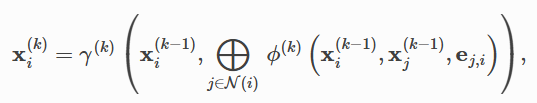

- x_i(k-1): (k-1) layer에서 i node의 node feature
- e_j,i: (optional) node j -> i의 edge feature
- 큰동그라미+: differentiable, permutation invariant function (e.g. sum, mean, max, ...)
- gamma, pi: differentiable function (e.g. MLP, ...)

< MessagePassing 순서 >
0. propagate() 호출: MessagePassing 시작함을 의미
1. message(): edge-level message
    - propagate() 내부에서 호출됨 
    - 이의 반환값이 aggregation 됨
    - 위 공식에서는 'pi'를 의미
2. aggregation: node-level aggregation
    - propagate()가 message()의 반환값을 가지고 aggregation 수행
    - target node별로 모든 이웃 노드의 메시지(message()의 반환값)를 더함
    - aggr="add", "mean", or "max" 등 사용자가 선정한 것에 따라 수행
    - 위 공식에서는 '큰동그라미+'를 의미
    - 보통 여기서의 output이 최종 output (새로운 node embedding(=node feature))
3. update: (optional)
    - aggregation 한 후에 '후처리 기능 추가 시' 사용 (ex. skip connection, batch 정규화 등)
    - 대부분의 경우 update() 사용 X
    - 위 공식에서는 'gamma'를 의미

#### Implementing the GCN layer

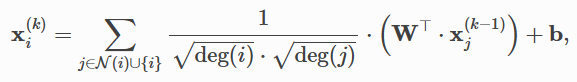

In [2]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [ ]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        # x @ self.lin.weight.T를 수행하는 선형 변환 (bias=False이므로 +bias 없음)
        # (x.shape: [N, in_channels], self.lin.weight.shape: [out_channels, in_channels])
        self.bias = Parameter(torch.empty(out_channels))
        # 학습 가능한 bias 파라미터 (shape: [out_channels])
        # torch.empty() -> 메모리만 잡아놓고 값은 초기화하지 않음

        self.reset_parameters()
        # self.lin.reset_parameters() -> 선형 변환의 weight 초기화
        # self.bias.data.zero_() -> bias를 0으로 초기화
        # forward() 마지막에 각 노드 embedding(=output)에 같은 bias 벡터를 더해줌

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # linear transformation -> normalization -> message passing -> bias addition
        
        # (before self.lin(x)) x.shape: [N, in_channels]
        # edge_index.shpae: [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        # (after self.lin(x)) x.shape: [N, out_channels]
        # 각 노드의 feature vector(길이 in_channels)에 
        # 같은 weight matrix(self.lin.weight.T)을 곱해서
        # 새로운 feature vector(길이 out_channels)로 변환

        # Step 3: Compute normalization.
        # norm 계산(degree normalization) -> edge weight(이것은 edge_attr로 사용)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        # node-level aggregation 
        # Step 5는 propagate()에서 수행 (propagate() 내부에서 message()가 호출됨)
        out = self.propagate(edge_index, x=x, norm=norm)
        # out.shape: [N, out_channels]
        # target node 별로 모든 이웃 노드의 메시지를 aggreation한 결과

        # Step 6: Apply a final bias vector.
        out = out + self.bias
        # 최종 output: 새로운 node embedding(=node feature) (shape: [N, out_channels])

        return out

    def message(self, x_j, norm):
        # edge-level message
        # x_j: 이웃 노드의 feature (shape: [num_edges(E), out_channels])

        # Step 4: Normalize node features.
        # 아직 node-level aggregation은 수행 전
        return norm.view(-1, 1) * x_j
        # norm.view(-1, 1): edge 별 normalization weight (shape: [E, 1])
        # * x_j: 각 edge마다 weight가 적용된 message (shape: [E, out_channels])

        # Step 5: Start propagating messages
        # propagate()가 message()의 반환값을 가지고 aggregation 수행 
        # => target node별로 모든 이웃 노드의 메시지를 더함 (= node-level aggregation)
        # 그 결과가 forward()의 out 변수에 저장

In [13]:
from torch_geometric.data import Data

# example data

# node feature matrix (N: number of nodes, F: number of features)
num_nodes = 10     # N (number of nodes)
in_channels = 16   # F (number of input features = conv input dimension)
x = torch.randn((num_nodes, in_channels))  # (10, 16)

# edge_index
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [1, 2, 3, 4, 5, 6, 7, 8, 9]
], dtype=torch.long)  # shape [2, 9]

# Data 객체 (선택)
data = Data(x=x, edge_index=edge_index)
# x와 edge_index로 설정
x, edge_index = data.x, data.edge_index

In [5]:
x, edge_index, x.shape, edge_index.shape

(tensor([[-0.1557, -0.6340,  0.9235, -0.1283,  1.6766, -0.1998, -0.3548, -0.0600,
          -0.5952, -0.6054, -2.6622, -0.2903, -2.1100, -0.6973,  0.0069, -1.7315],
         [-1.1252, -0.1487, -0.8301, -0.1562,  0.8740,  0.8406,  2.1420,  0.6281,
          -1.2890, -0.2314, -0.0507, -0.3933, -0.1380, -0.2212,  0.3423,  1.1930],
         [ 0.7579,  0.1842, -1.1967, -0.4789,  0.6266,  0.5069, -0.8254, -1.5471,
          -0.1261,  0.3653, -1.5065,  0.8333, -1.4173, -1.0574, -0.0937, -0.9320],
         [-0.3772,  0.8901, -0.8133,  1.7867,  0.7926,  0.5603,  0.5234, -0.7247,
          -0.7521, -0.5998, -0.6681, -0.4501,  0.5465, -0.8794, -1.1399, -1.2021],
         [ 0.6263,  1.2276,  0.7314,  0.3718, -0.4399, -0.4467, -0.1013, -0.1700,
          -0.4564,  0.6543, -1.9673, -0.2404,  0.9518, -0.5707,  1.2592, -0.3991],
         [-1.3911, -0.4194, -0.4412,  1.9082, -0.3259, -0.8498,  0.3659, -1.0969,
          -1.1946, -0.7859, -1.0705, -0.5274, -0.0306, -1.0431,  0.3531, -1.7352],
         [

In [6]:
conv = GCNConv(16, 32)
new_x = conv(x, edge_index)

In [7]:
new_x   # nwe_x.shape: [num_nodes, out_channels] = [10, 32]
# 이웃 노드 정보까지 모두 반영된 새로운 node embedding (= node feature)
# 즉, message passing의 최종 결과

tensor([[-0.7044,  0.1420, -0.5486,  0.1332, -0.9705,  0.7100,  0.4120, -0.1445,
          0.6693, -0.7319,  0.8884, -0.3125, -0.5069,  0.3522, -0.5071, -0.2439,
          0.0421, -0.2393,  0.1231,  1.2130,  0.2865, -0.7532,  0.5559,  0.2047,
          0.1097,  0.4924, -0.5982, -0.0792,  1.0022, -0.2331, -0.2585, -0.5435],
        [-0.0649, -0.0163, -0.4648,  0.2509, -0.9227,  0.4041, -0.0218, -0.2939,
          0.0147, -0.5449,  0.3797, -0.2877, -0.0707,  0.1010, -0.5315, -0.5065,
         -0.0431, -0.2452, -0.1999,  0.6841, -0.2047, -0.5453,  0.4491, -0.2308,
          0.2037,  0.7959, -0.1516,  0.1993,  0.8564, -0.1138, -0.2719, -0.1512],
        [ 0.3164, -0.1833, -0.1918, -0.0160, -0.0255, -0.0975, -0.3071, -0.4730,
          0.0092,  0.1755,  0.2879, -0.4840,  0.1705, -0.2060, -0.4538, -0.3294,
          0.0756, -0.0391, -0.2046,  0.2110, -0.0986, -0.2082,  0.4362, -0.2069,
          0.1331,  0.7108,  0.3772,  0.4337,  0.5170,  0.1955,  0.2599,  0.0629],
        [ 0.3751,  0.1971

#### Implementing the Edge Convolution

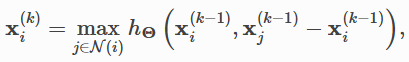

In [1]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

In [ ]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') #  "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))
        # self.mlp: edge 별 messaage(관계 표현 (feature))를 만드는 신경망
        # 2 layers MLP: Linear 1 -> ReLU -> Linear 2
        # Linear 1: tmp @ W1 + b1 -> [E, 2*in_channels] @ [2*in_channels, out_channels] = [E, out_channels]
        # Linear 2: [E, out_channels] @ W2 + b2 -> [E, out_channels] @ [out_channels, out_channels] = [E, out_channels]

    def forward(self, x, edge_index):
        # x.shape [N, in_channels], edge_index.shape [2, E]

        # normalization 없는 이유: "관계(feature 차이)" 중심 -> edge weight 필요 없음
        # GCNConv: degree 정규화를 통해 sum aggregation을 통해 scale이 커지는 것을 방지
        # EdgeConv: max aggregation사용(단순 최대값)을 사용 -> scale이 커지는 문제 없음

        # self-loops 추가 안하는 이유: "관계(feature 차이)" 중심 -> 자기 자신과의 관계는 의미 없음
        # GCNConv: sum/mean aggr을 하기 때문에 자기 자신 정보가 사라지지 않도록 하기 위해서 self-loops 추가 (자기 정보도 같이 sum/mean)
        # EdgeConv: message() 계산에 x_i(자기 자신 feature)가 들어가기 때문에 자기 자신 정보가 사라지지 않음

        return self.propagate(edge_index, x=x)
        # propagate() 호출 -> 내부에서 message() 호출 -> message() 반환값으로 node-level aggregation 수행 (-> update() 호출(optional))

    def message(self, x_i, x_j):
        # x_i: 현재 node의 feature (shape: [E, in_channels])
        # x_j-x_i: 이웃과의 상대적 차이(= edge 방향성 + 관계의 특성) (shape: [E, in_channels])

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  
        # tmp: 자신과 이웃 노드와의 관계를 표현하는 edge-level feature (shape: [E, 2 * in_channels])
        # 엣지 별 관계 embedding (feature)
        # 엣지 하나당 하나의 메세지를 계산해서 반환

        # dim=1: [E, in_channels + in_channels] = [E, 2 * in_channels]
        # 즉, feature dimension 기준으로 concat
        # (dim=0이었다면, [in_channels, E + E] = [in_channels, 2 * E])
        return self.mlp(tmp)


In [14]:
conv = EdgeConv(16, 32)
new_x_edge = conv(x, edge_index)

In [16]:
new_x_edge, new_x_edge.shape

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0795,  0.4352,  0.0347,  0.3308, -0.2521,  0.0338, -0.0346,  0.3507,
           0.4247, -0.0457,  0.3659,  0.0986, -0.2224,  0.1793, -0.0667,  0.1005,
          -0.0350,  0.6152, -0.4096, -0.2532, -0.1143,  0.3358, -0.0113,  0.2455,
           0.0236,  0.2381, -0.4448, -0.4522, -0.0812, -0.2838,  0.1898, -0.5406],
         [-0.0440,  0.6622,  0.3829, -0.0832, -0.3322, -0.3408, -0.2706,  0.3652,
           0.2327, -0.1484, -0.3788,  0.1236, -0.0976, -0.0059, -0.1401, -0.3182,
           0.1191, -0.0755,  0.0722, -0.8677, -0.0345,  0.0535,  0.3178,  0.0615,
           0.5098,  0.6048, -0.1523, -0.0704, -0.0991, -0.0456, -0.3984,  0.2766],
         [-0.

In [ ]:
from torch_geometric.nn import knn_graph

# EdgeConv: 고정된 edge_index 사용 
    # edge_index 고정 -> feature 변화에 따른 neighbor 관계 반영 X
# DynamicEdgeConv: 매 forward()마다 KNN으로 edge_index 새로 계산
    # feature 변화에 따라 neighbor 동적으로 선정 -> 적응적 관계 학습 가능

class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=6):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)
        # x를 기준으로 KNN 계산 -> 각 node마다 k개의 nearset neighbors를 찾음
        # 즉, 각 node마다 동적으로 KNN edge_index 생성
        return super().forward(x, edge_index)   # 기존 EdgeConv의 forward() 호출
    

    # batch: 각 노드가 속한 서브 그래프의 인덱스 (shape: [N])

In [3]:
# example data

# 10 nodes, each with 3 features
num_nodes = 10     # N (number of nodes)
in_channels = 3   # F (number of input features = conv input dimension)
out_channels = 128
k = 6

# node feature matrix (N: number of nodes, F: number of features)
x = torch.rand((num_nodes, in_channels))  # (10, 3)

# batch vector (all nodes belong to the same graph in single graph example)
# (single graph이므로 모두 0)
batch = torch.zeros(num_nodes, dtype=torch.long)  # (10,)

In [4]:
x, batch, x.shape, batch.shape

(tensor([[0.0548, 0.7611, 0.4593],
         [0.6971, 0.7277, 0.2306],
         [0.3562, 0.0855, 0.3930],
         [0.8342, 0.2655, 0.5425],
         [0.5323, 0.3262, 0.6632],
         [0.2649, 0.4672, 0.5894],
         [0.7538, 0.3994, 0.8372],
         [0.0619, 0.2658, 0.7181],
         [0.8886, 0.7315, 0.9804],
         [0.3624, 0.8012, 0.3642]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 torch.Size([10, 3]),
 torch.Size([10]))

In [ ]:
conv = DynamicEdgeConv(in_channels, out_channels, k=k)
x = conv(x, batch)

# x.shape: [num_nodes, out_channels] = [10, 128]
# x[i]: node i의 새로운 embedding (feature) (shape: [out_channels])

ImportError: 'knn_graph' requires 'torch-cluster'

##### checking Pytorch version & Installation

In [7]:
torch.__version__

'2.8.0+cpu'

In [8]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.8.0+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html
     ---------------------------------------- 0.0/769.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/769.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/769.7 kB ? eta -:--:--
     ------------- -------------------------- 262.1/769.7 kB ? eta -:--:--
     ---------------------------------------- 769.7/769.7 kB 3.1 MB/s  0:00:00


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/525.7 kB ? eta -:--:--
     ------------------- -------------------- 262.1/525.7 kB ? eta -:--:--
     ---------------------------------------- 525.7/525.7 kB 1.6 MB/s  0:00:00


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html


In [11]:
import torch
import torch_geometric
from torch_geometric.nn import knn_graph

print(torch.__version__)        # 2.8.0+cpu
print(torch_geometric.__version__)  # 설치된 버전 확인

2.8.0+cpu
2.7.0


Python 3.13 + PyTorch 2.8 CPU에서는 torch-cluster 지원 X
(-> Python 3.10~3.11 + Pytorch 2.2~2.6 환경으로 바꿔줘야 함)